## Price Predictions for TSLA Stock

In [1]:
# dependencies (Keras, math, pandas, etc.)
from __future__ import print_function
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional
from keras.models import Sequential
from sklearn.cross_validation import  train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import math



/Users/ryan/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/ryan/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/ryan/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarnin

In [39]:
# create our hyperparameters as well as create a random seed for reproducability
look_back = 7
epochs = 1000
batch_size = 32

# import our data that we need
tesla = pd.read_csv('data/TeslaPriceHistory.csv')
# flip our data so the first stock values come first in order of time (2010 came before 2018)
tesla = tesla.iloc[::-1]
tesla.head()

,date,close,volume,open,high,low
1906,2010/06/29,23.89,18751150.0000,19.00,25.0000,17.54
1905,2010/06/30,23.83,17165210.0000,25.79,30.4192,23.30
1904,2010/07/01,21.96,8216789.0000,25.00,25.9200,20.27
1903,2010/07/02,19.20,5135795.0000,23.00,23.1000,18.71
1902,2010/07/06,16.11,6858092.0000,20.00,20.0000,15.83


In [40]:
# plot our data to get an idea of what's going on
prices = tesla.close.values.astype('float32')
# reshape our data so it is column vector format
prices = prices.reshape(len(prices), 1)

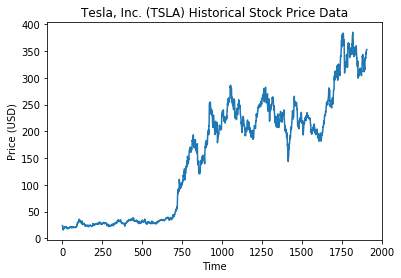

In [41]:
# print our data for visualization purposes
plt.plot(prices)
plt.title("Tesla, Inc. (TSLA) Historical Stock Price Data")
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.show()

In [42]:
# normalize our data so that everything is a wee bit closer together
normalizer = MinMaxScaler(feature_range=(0,1))
normalizedPrices = normalizer.fit_transform(prices)

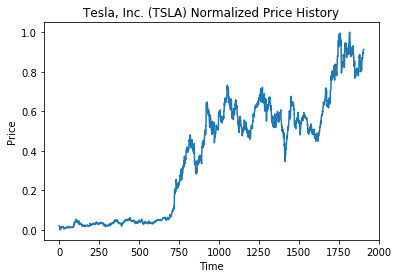

In [43]:
# plot our normalized values to show the difference
plt.plot(normalizedPrices)
plt.title("Tesla, Inc. (TSLA) Normalized Price History")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

In [44]:
# split our data into training and testing data
# 67% for training and 33% for testing
trainingSize = int(len(normalizedPrices) * 0.67)
testingSize = len(normalizedPrices - trainingSize)

# this grabs the first 67% of the data as training data, and the last 33% as the testing data
training, testing = normalizedPrices[0:trainingSize, :], normalizedPrices[trainingSize:len(normalizedPrices), :]

print("Training:", len(training))
print("Testing:", len(testing))

Training: 1277
Testing: 630


In [45]:
# we do this because we'd like to be able to look behind and ahead of the current price to try to gauge what the value should be

# convert an array of values into a time series dataset 
# in form 
#                     X                     Y
# t-look_back+1, t-look_back+2, ..., t     t+1

def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for index in range(len(dataset)-look_back-1):
        a = dataset[index:(index+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[index + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [81]:
# create our dataset that we'll send into the network for analysis
trainX, trainY = create_dataset(training, look_back)
testX, testY = create_dataset(testing, look_back)

In [82]:
# reshape the input of the LSTM to be formatted as [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [50]:
# create our Sequential Model which will be a Birdirectional LSTM Recurrent Network
# this is our graph type, it's analogous to a singly linked list, whereas another type of model would be like a DAG (Directed Acyclic Graph)
model = Sequential()

# add our first Bidirectional LSTM layer
model.add(Bidirectional(LSTM(4, return_sequences=True), input_shape=(look_back, 1)))
model.add(Dropout(0.2))

# add the second LSTM block
model.add(Bidirectional(LSTM(8, return_sequences=True)))
model.add(Dropout(0.2))

# add the final LSTM block
model.add(Bidirectional(LSTM(4, return_sequences=False)))

# add our dense layer
model.add(Dense(units=1))

# compile the model using mean squared error as the loss function, and adam optimizer as our optimizer
model.compile(loss='mse', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 7, 8)              192       
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 8)              0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 7, 16)             1088      
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 16)             0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 8)                 672       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 1,961
Trainable params: 1,961
Non-trainable params: 0
_________________________________________________________________


In [51]:
# train the model on our training data
model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size)

Epoch 1/1000
1269/1269 [==============================] - 5s 4ms/step - loss: 0.0640
Epoch 2/1000
1269/1269 [==============================] - 1s 557us/step - loss: 0.0169
Epoch 3/1000
1269/1269 [==============================] - 1s 561us/step - loss: 0.0021
Epoch 4/1000
1269/1269 [==============================] - 1s 559us/step - loss: 0.0016
Epoch 5/1000
1269/1269 [==============================] - 1s 559us/step - loss: 0.0015
Epoch 6/1000
1269/1269 [==============================] - 1s 570us/step - loss: 0.0015
Epoch 7/1000
1269/1269 [==============================] - 1s 562us/step - loss: 0.0016
Epoch 8/1000
1269/1269 [==============================] - 1s 559us/step - loss: 0.0013
Epoch 9/1000
1269/1269 [==============================] - 1s 559us/step - loss: 0.0013
Epoch 10/1000
1269/1269 [==============================] - 1s 560us/step - loss: 0.0013
Epoch 11/1000
1269/1269 [==============================] - 1s 557us/step - loss: 0.0012
Epoch 12/1000
1269/1269 [==================

Epoch 91/1000
1269/1269 [==============================] - 1s 555us/step - loss: 5.2122e-04
Epoch 92/1000
1269/1269 [==============================] - 1s 557us/step - loss: 5.7255e-04
Epoch 93/1000
1269/1269 [==============================] - 1s 554us/step - loss: 5.0842e-04
Epoch 94/1000
1269/1269 [==============================] - 1s 557us/step - loss: 5.2175e-04
Epoch 95/1000
1269/1269 [==============================] - 1s 560us/step - loss: 4.8494e-04
Epoch 96/1000
1269/1269 [==============================] - 1s 558us/step - loss: 4.8920e-04
Epoch 97/1000
1269/1269 [==============================] - 1s 553us/step - loss: 5.0737e-04
Epoch 98/1000
1269/1269 [==============================] - 1s 557us/step - loss: 4.9178e-04
Epoch 99/1000
1269/1269 [==============================] - 1s 558us/step - loss: 5.2271e-04
Epoch 100/1000
1269/1269 [==============================] - 1s 557us/step - loss: 4.7903e-04
Epoch 101/1000
1269/1269 [==============================] - 1s 558us/step - los

1269/1269 [==============================] - 1s 557us/step - loss: 3.7800e-04
Epoch 180/1000
1269/1269 [==============================] - 1s 558us/step - loss: 3.5164e-04
Epoch 181/1000
1269/1269 [==============================] - 1s 557us/step - loss: 3.9030e-04
Epoch 182/1000
1269/1269 [==============================] - 1s 558us/step - loss: 3.9463e-04
Epoch 183/1000
1269/1269 [==============================] - 1s 555us/step - loss: 3.3068e-04
Epoch 184/1000
1269/1269 [==============================] - 1s 554us/step - loss: 3.5213e-04
Epoch 185/1000
1269/1269 [==============================] - 1s 558us/step - loss: 3.4043e-04
Epoch 186/1000
1269/1269 [==============================] - 1s 557us/step - loss: 3.5935e-04
Epoch 187/1000
1269/1269 [==============================] - 1s 556us/step - loss: 3.9128e-04
Epoch 188/1000
1269/1269 [==============================] - 1s 556us/step - loss: 3.8447e-04
Epoch 189/1000
1269/1269 [==============================] - 1s 555us/step - loss: 3.5

1269/1269 [==============================] - 1s 555us/step - loss: 3.1152e-04
Epoch 268/1000
1269/1269 [==============================] - 1s 558us/step - loss: 3.0491e-04
Epoch 269/1000
1269/1269 [==============================] - 1s 555us/step - loss: 3.0069e-04
Epoch 270/1000
1269/1269 [==============================] - 1s 559us/step - loss: 3.3291e-04
Epoch 271/1000
1269/1269 [==============================] - 1s 558us/step - loss: 3.0824e-04
Epoch 272/1000
1269/1269 [==============================] - 1s 555us/step - loss: 3.2655e-04
Epoch 273/1000
1269/1269 [==============================] - 1s 557us/step - loss: 3.2915e-04
Epoch 274/1000
1269/1269 [==============================] - 1s 557us/step - loss: 3.0415e-04
Epoch 275/1000
1269/1269 [==============================] - 1s 555us/step - loss: 3.3751e-04
Epoch 276/1000
1269/1269 [==============================] - 1s 556us/step - loss: 2.9556e-04
Epoch 277/1000
1269/1269 [==============================] - 1s 559us/step - loss: 2.9

1269/1269 [==============================] - 1s 558us/step - loss: 3.1554e-04
Epoch 356/1000
1269/1269 [==============================] - 1s 557us/step - loss: 3.0522e-04
Epoch 357/1000
1269/1269 [==============================] - 1s 555us/step - loss: 2.8471e-04
Epoch 358/1000
1269/1269 [==============================] - 1s 556us/step - loss: 3.0752e-04
Epoch 359/1000
1269/1269 [==============================] - 1s 555us/step - loss: 2.6178e-04
Epoch 360/1000
1269/1269 [==============================] - 1s 554us/step - loss: 2.6950e-04
Epoch 361/1000
1269/1269 [==============================] - 1s 558us/step - loss: 3.0057e-04
Epoch 362/1000
1269/1269 [==============================] - 1s 557us/step - loss: 3.1395e-04
Epoch 363/1000
1269/1269 [==============================] - 1s 556us/step - loss: 3.0149e-04
Epoch 364/1000
1269/1269 [==============================] - 1s 551us/step - loss: 3.1841e-04
Epoch 365/1000
1269/1269 [==============================] - 1s 545us/step - loss: 2.8

1269/1269 [==============================] - 1s 554us/step - loss: 3.0445e-04
Epoch 444/1000
1269/1269 [==============================] - 1s 553us/step - loss: 2.7816e-04
Epoch 445/1000
1269/1269 [==============================] - 1s 554us/step - loss: 2.7194e-04
Epoch 446/1000
1269/1269 [==============================] - 1s 555us/step - loss: 2.4900e-04
Epoch 447/1000
1269/1269 [==============================] - 1s 551us/step - loss: 2.5544e-04
Epoch 448/1000
1269/1269 [==============================] - 1s 554us/step - loss: 2.7821e-04
Epoch 449/1000
1269/1269 [==============================] - 1s 555us/step - loss: 2.8178e-04
Epoch 450/1000
1269/1269 [==============================] - 1s 552us/step - loss: 2.7911e-04
Epoch 451/1000
1269/1269 [==============================] - 1s 553us/step - loss: 2.9464e-04
Epoch 452/1000
1269/1269 [==============================] - 1s 555us/step - loss: 2.7383e-04
Epoch 453/1000
1269/1269 [==============================] - 1s 554us/step - loss: 2.6

1269/1269 [==============================] - 1s 555us/step - loss: 2.4476e-04
Epoch 532/1000
1269/1269 [==============================] - 1s 550us/step - loss: 2.4757e-04
Epoch 533/1000
1269/1269 [==============================] - 1s 544us/step - loss: 2.4984e-04
Epoch 534/1000
1269/1269 [==============================] - 1s 558us/step - loss: 2.5684e-04
Epoch 535/1000
1269/1269 [==============================] - 1s 550us/step - loss: 2.6565e-04
Epoch 536/1000
1269/1269 [==============================] - 1s 554us/step - loss: 2.6835e-04
Epoch 537/1000
1269/1269 [==============================] - 1s 553us/step - loss: 2.6074e-04
Epoch 538/1000
1269/1269 [==============================] - 1s 553us/step - loss: 2.6977e-04
Epoch 539/1000
1269/1269 [==============================] - 1s 555us/step - loss: 2.6305e-04
Epoch 540/1000
1269/1269 [==============================] - 1s 552us/step - loss: 2.7139e-04
Epoch 541/1000
1269/1269 [==============================] - 1s 554us/step - loss: 2.6

1269/1269 [==============================] - 1s 558us/step - loss: 2.2408e-04
Epoch 620/1000
1269/1269 [==============================] - 1s 551us/step - loss: 2.2589e-04
Epoch 621/1000
1269/1269 [==============================] - 1s 554us/step - loss: 2.2534e-04
Epoch 622/1000
1269/1269 [==============================] - 1s 555us/step - loss: 2.6821e-04
Epoch 623/1000
1269/1269 [==============================] - 1s 552us/step - loss: 2.5503e-04
Epoch 624/1000
1269/1269 [==============================] - 1s 552us/step - loss: 2.2046e-04
Epoch 625/1000
1269/1269 [==============================] - 1s 555us/step - loss: 2.6100e-04
Epoch 626/1000
1269/1269 [==============================] - 1s 553us/step - loss: 2.2109e-04
Epoch 627/1000
1269/1269 [==============================] - 1s 556us/step - loss: 2.0458e-04
Epoch 628/1000
1269/1269 [==============================] - 1s 553us/step - loss: 2.1181e-04
Epoch 629/1000
1269/1269 [==============================] - 1s 553us/step - loss: 2.2

1269/1269 [==============================] - 1s 554us/step - loss: 2.1666e-04
Epoch 708/1000
1269/1269 [==============================] - 1s 555us/step - loss: 2.1837e-04
Epoch 709/1000
1269/1269 [==============================] - 1s 553us/step - loss: 2.2900e-04
Epoch 710/1000
1269/1269 [==============================] - 1s 556us/step - loss: 2.0891e-04
Epoch 711/1000
1269/1269 [==============================] - 1s 551us/step - loss: 2.1203e-04
Epoch 712/1000
1269/1269 [==============================] - 1s 550us/step - loss: 2.2362e-04
Epoch 713/1000
1269/1269 [==============================] - 1s 552us/step - loss: 2.0861e-04
Epoch 714/1000
1269/1269 [==============================] - 1s 551us/step - loss: 2.1776e-04
Epoch 715/1000
1269/1269 [==============================] - 1s 551us/step - loss: 2.1703e-04
Epoch 716/1000
1269/1269 [==============================] - 1s 556us/step - loss: 2.1393e-04
Epoch 717/1000
1269/1269 [==============================] - 1s 559us/step - loss: 2.1

1269/1269 [==============================] - 1s 558us/step - loss: 1.9340e-04
Epoch 796/1000
1269/1269 [==============================] - 1s 558us/step - loss: 2.1245e-04
Epoch 797/1000
1269/1269 [==============================] - 1s 557us/step - loss: 2.0901e-04
Epoch 798/1000
1269/1269 [==============================] - 1s 551us/step - loss: 1.9321e-04
Epoch 799/1000
1269/1269 [==============================] - 1s 558us/step - loss: 2.2038e-04
Epoch 800/1000
1269/1269 [==============================] - 1s 556us/step - loss: 2.0336e-04
Epoch 801/1000
1269/1269 [==============================] - 1s 557us/step - loss: 2.0371e-04
Epoch 802/1000
1269/1269 [==============================] - 1s 556us/step - loss: 1.9621e-04
Epoch 803/1000
1269/1269 [==============================] - 1s 557us/step - loss: 2.2072e-04
Epoch 804/1000
1269/1269 [==============================] - 1s 557us/step - loss: 2.0105e-04
Epoch 805/1000
1269/1269 [==============================] - 1s 557us/step - loss: 1.9

1269/1269 [==============================] - 1s 561us/step - loss: 1.8202e-04
Epoch 884/1000
1269/1269 [==============================] - 1s 557us/step - loss: 2.0746e-04
Epoch 885/1000
1269/1269 [==============================] - 1s 556us/step - loss: 1.9734e-04
Epoch 886/1000
1269/1269 [==============================] - 1s 558us/step - loss: 2.1810e-04
Epoch 887/1000
1269/1269 [==============================] - 1s 556us/step - loss: 1.7950e-04
Epoch 888/1000
1269/1269 [==============================] - 1s 558us/step - loss: 1.9330e-04
Epoch 889/1000
1269/1269 [==============================] - 1s 558us/step - loss: 1.9505e-04
Epoch 890/1000
1269/1269 [==============================] - 1s 557us/step - loss: 2.0165e-04
Epoch 891/1000
1269/1269 [==============================] - 1s 560us/step - loss: 1.8869e-04
Epoch 892/1000
1269/1269 [==============================] - 1s 556us/step - loss: 2.0560e-04
Epoch 893/1000
1269/1269 [==============================] - 1s 556us/step - loss: 1.9

1269/1269 [==============================] - 1s 557us/step - loss: 1.9107e-04
Epoch 972/1000
1269/1269 [==============================] - 1s 556us/step - loss: 2.1444e-04
Epoch 973/1000
1269/1269 [==============================] - 1s 556us/step - loss: 1.9119e-04
Epoch 974/1000
1269/1269 [==============================] - 1s 555us/step - loss: 1.8818e-04
Epoch 975/1000
1269/1269 [==============================] - 1s 553us/step - loss: 1.7550e-04
Epoch 976/1000
1269/1269 [==============================] - 1s 555us/step - loss: 2.1807e-04
Epoch 977/1000
1269/1269 [==============================] - 1s 555us/step - loss: 1.9937e-04
Epoch 978/1000
1269/1269 [==============================] - 1s 555us/step - loss: 1.9710e-04
Epoch 979/1000
1269/1269 [==============================] - 1s 558us/step - loss: 2.1293e-04
Epoch 980/1000
1269/1269 [==============================] - 1s 558us/step - loss: 2.0541e-04
Epoch 981/1000
1269/1269 [==============================] - 1s 557us/step - loss: 1.9

In [83]:
# predict some values
trainPredictions = model.predict(trainX)
testPredictions = model.predict(testX)

In [84]:
# redefine the values of the predictions to get the actual number
trainPredictions = normalizer.inverse_transform(trainPredictions)
trainY = normalizer.inverse_transform([trainY])
testPredictions = normalizer.inverse_transform(testPredictions)
testY = normalizer.inverse_transform([testY])

In [86]:
# calculate the error of our prediction
# Root Mean Squared Error
trainingScore = math.sqrt(mean_squared_error(trainY[0], trainPredictions[:, 0]))
testingScore = math.sqrt(mean_squared_error(testY[0], testPredictions[:, 0]))

print("Training Score: %.5f RMSE" % (trainingScore))
print("Testing Score: %.5f RMSE" % (testingScore))

Training Score: 5.15793 RMSE
Testing Score: 27.37912 RMSE


In [87]:
# shift predictions of training data for plotting
trainPredictionPlot = np.empty_like(prices)
trainPredictionPlot[:, :] = np.nan
trainPredictionPlot[look_back:len(trainPredictions)+look_back, :] = trainPredictions

# shift predictions of testing data for plotting
testPredictionPlot = np.empty_like(prices)
testPredictionPlot[:, :] = np.nan
testPredictionPlot[len(trainPredictions)+(look_back*2)+1:len(prices)-1, :] = testPredictions

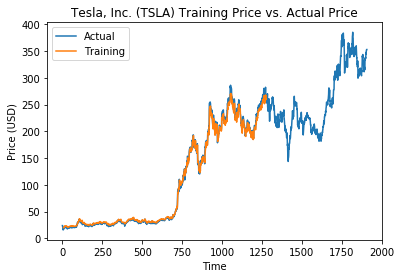

In [99]:
# plot the data
plt.plot(prices, label="Actual")
plt.plot(trainPredictionPlot, label="Training")
plt.title("Tesla, Inc. (TSLA) Training Price vs. Actual Price")
plt.ylabel("Price (USD)")
plt.xlabel("Time")
plt.legend()
plt.show()

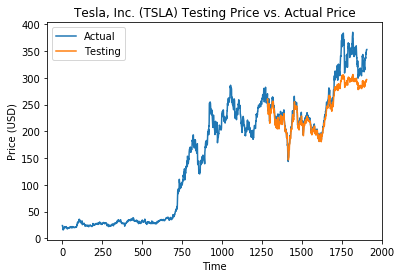

In [97]:
plt.plot(prices, label="Actual")
plt.plot(testPredictionPlot, label="Testing")
plt.title("Tesla, Inc. (TSLA) Testing Price vs. Actual Price")
plt.ylabel("Price (USD)")
plt.xlabel("Time")
plt.legend()
plt.show()

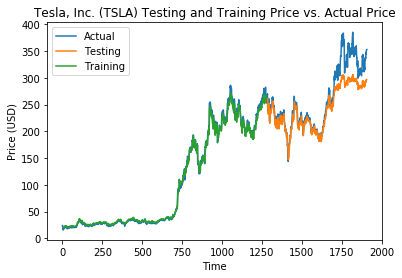

In [96]:
plt.plot(prices, label='Actual')
plt.plot(testPredictionPlot, label='Testing')
plt.plot(trainPredictionPlot, label='Training')
plt.title("Tesla, Inc. (TSLA) Testing and Training Price vs. Actual Price")
plt.ylabel("Price (USD)")
plt.xlabel("Time")
plt.legend()
plt.show()

In [115]:
# see if we can predict the entire model just by testing data
fullDataSetX, fullDataSetY = create_dataset(normalizedPrices, look_back)
# reshape the input
fullTestX = np.reshape(fullDataSetX, (fullDataSetX.shape[0], fullDataSetX.shape[1], 1))
fullTest = model.predict(fullTestX)

# invert the normalization for display and root mean squared error
fullTestPredictions = normalizer.inverse_transform(fullTest)
fullTestY = normalizer.inverse_transform([fullDataSetY])


fullTestError = math.sqrt(mean_squared_error(fullTestY[0], fullTestPredictions[:, 0]))
print("Full Test Error: %.5f RMSE" % (fullTestError))

Full Test Error: 16.23816 RMSE


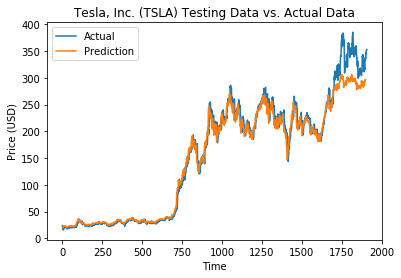

In [116]:
## plot the full testing data compared to the actual stock data
plt.plot(prices, label="Actual")
plt.plot(fullTestPredictions, label="Prediction")
plt.title("Tesla, Inc. (TSLA) Testing Data vs. Actual Data")
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()